# Defining subdomains for different materials
Author: Jørgen S. Dokken

Solving PDEs in domains made up of different materials is frequently encountered task. In FEniCSx, we handle these problems by defining a Discontinous cell-wise constant function.
Such a function can be created over any mesh in the following way
## Subdomains on built-in meshes

In [1]:
import dolfinx
from mpi4py import MPI

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)
Q = dolfinx.FunctionSpace(mesh, ("DG", 0))

We will use a simple example with two materials in two dimensions to demonstrate the idea. The whole domain will be $\Omega=[0,1]\times[0,1]$, which consists of two subdomains 
$\Omega_0=[0,1]\times [0,1/2]$ and $\Omega_1=[0,1]\times[1/2, 1]$. We start by creating two python functions, where each returns `True` if the input coordinate is inside its domain.

In [2]:
def Omega_0(x):
    return x[1] <= 0.5

def Omega_1(x):
    return x[1] >= 0.5

Note that both fucntion uses a $\leq$ or $\geq$, as FEniCSx will evaluate each cell at all of the vertices, and thus for has to return `True` for all vertices align with the interface to be marked properly.

We will solve a variable-coefficient extension of the Poisson equation

$$
-\nabla \cdot [\kappa (x,y)\nabla u(x, y)]= 1 \qquad \text{in } \Omega,
$$
$$
u=u_D=1 \qquad \text{on } \partial\Omega_D=[0,y], y\in[0,1]
$$
$$
-\frac{\partial u}{\partial n}=0 \qquad \text{on } \partial\Omega\setminus \partial\Omega_D
$$

Our next step is to define $\kappa$

In [3]:
kappa = dolfinx.Function(Q)
cells_0 = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim, Omega_0)
cells_1 = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim, Omega_1)

In the previous code block, we found which cells (triangular elements) which satisfies the condition for being in $\Omega_0, \Omega_1$. As the $DG-0$ function contain only one degree of freedom per mesh, there is a one to one mapping between the cell indicies and the degrees of freedom. We let $\kappa=\begin{cases}
1 &\text{if } x\in\Omega_0\\
0.1& \text{if } x\in\Omega_1\\
\end{cases}$

In [4]:
import numpy as np
with kappa.vector.localForm() as loc:
    loc.setValues(cells_0, np.full(len(cells_0), 1))
    loc.setValues(cells_1, np.full(len(cells_1), 0.1))

We are now ready to define our variational formulation and  Dirichlet boundary condition after using integration by parts 

In [5]:
import ufl
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = ufl.inner(kappa*ufl.grad(u), ufl.grad(v))*ufl.dx
x = ufl.SpatialCoordinate(mesh)
L = dolfinx.Constant(mesh, 1) * v * ufl.dx
dofs = dolfinx.fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
u_D = dolfinx.Function(V)
with u_D.vector.localForm() as loc:
    loc.setValues(dofs, np.full(len(dofs), 1))
bcs = [dolfinx.DirichletBC(u_D, dofs)]

We can now solve and visualize the solution of the problem

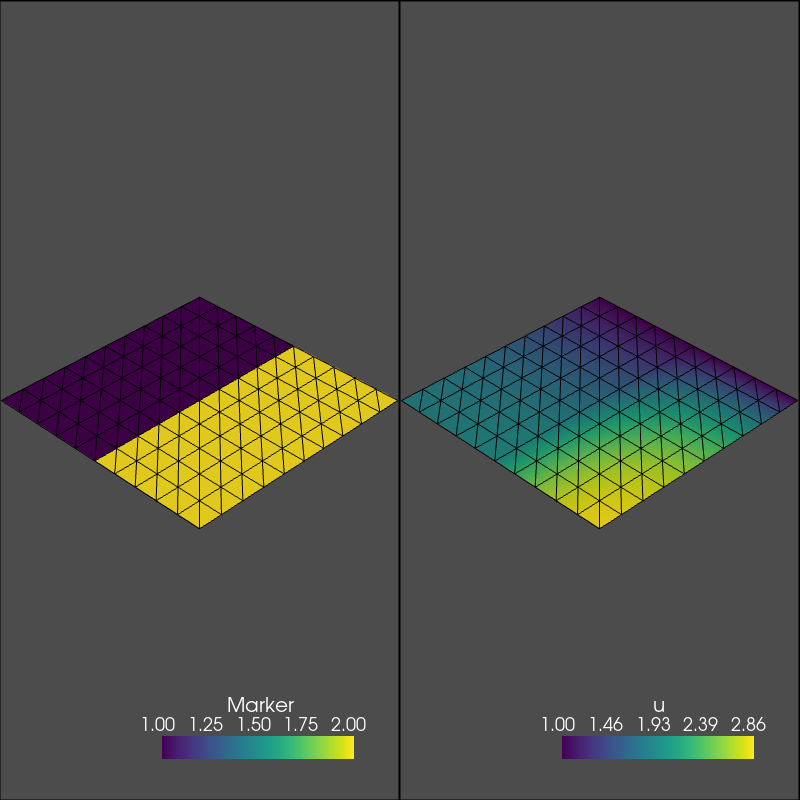

In [6]:
problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

import pyvista
# Start virtual framebuffer
pyvista.start_xvfb(wait=0.0)

import dolfinx.plot
p = pyvista.Plotter(window_size=[800, 800], shape=(1,2))
# Filter out ghosted cells
num_cells_local = mesh.topology.index_map(mesh.topology.dim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)
cells_0 = cells_0[cells_0<num_cells_local]
cells_1 = cells_1[cells_1<num_cells_local]
marker[cells_0] = 1
marker[cells_1] = 2
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim, np.arange(num_cells_local, dtype=np.int32))
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
grid.cell_arrays["Marker"] = marker
grid.set_active_scalars("Marker")
p.subplot(0,0)
actor0 = p.add_mesh(grid, show_edges=True)
p.subplot(0,1)
point_values = uh.compute_point_values()
if np.iscomplexobj(point_values):
    point_values = point_values.real
grid.point_arrays["u"] = point_values
grid.set_active_scalars("u")
actor1 = p.add_mesh(grid, show_edges=True)
if not pyvista.OFF_SCREEN:
    p.show()
figure = p.screenshot("subdomains_structured.png")

We clearly observe different behavior in the two regions, whose both has the same Dirichlet boundary condition on the left side, where $x=0$.

## Interpolation with Python-function
As we saw in the first approach, in many cases, we can use the geometrical coordinates to determine which coefficient we should use. Using the unstructured mesh from the previous example, we illustrate an alternative approach using interpolation:

In [7]:
from petsc4py import PETSc
def eval_kappa(x):
    values = np.zeros(x.shape[1],dtype=PETSc.ScalarType)
    # Create a boolean array indicating which dofs (corresponding to cell centers)
    # that are in each domain
    top_coords = x[1]>0.5 
    bottom_coords = x[1]<0.5
    values[top_coords] = np.full(sum(top_coords), 0.1)
    values[bottom_coords] = np.full(sum(bottom_coords), 1)
    return values
kappa2 = dolfinx.Function(Q)
kappa2.interpolate(eval_kappa)
dolfinx.cpp.la.scatter_forward(kappa2.x)

We verify this by assembling the error between this new function and the old one

In [8]:
# Difference in kappa's
error = mesh.mpi_comm().allreduce(dolfinx.fem.assemble_scalar((kappa-kappa2)**2*ufl.dx))
print(error)

0.0


## Subdomains defined from external mesh data
Let us now consider the same problem, but using GMSH to generate the mesh and subdomains. We will then in turn show how to use this data to generate discontinuous functions in DOLFINx.

In [9]:
import gmsh
gmsh.initialize()
proc = MPI.COMM_WORLD.rank 
top_marker = 2
bottom_marker = 1
left_marker = 1
if proc == 0:
    # We create one rectangle for each subdomain
    gmsh.model.occ.addRectangle(0, 0, 0, 1, 0.5, tag=1)
    gmsh.model.occ.addRectangle(0, 0.5, 0, 1, 0.5, tag=2)
    # We fuse the two rectangles and keep the interface between them 
    gmsh.model.occ.fragment([(2,1)],[(2,2)])
    gmsh.model.occ.synchronize()
   
    # Mark the top (2) and bottom (1) rectangle
    top, bottom = None, None
    for surface in gmsh.model.getEntities(dim=2):
        com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
        if np.allclose(com, [0.5,0.25, 0]):
            bottom = surface[1]
        else:
            top = surface[1]
    gmsh.model.addPhysicalGroup(2, [bottom], bottom_marker)
    gmsh.model.addPhysicalGroup(2, [top], top_marker)
    # Tag the left boundary
    left = []
    for line in gmsh.model.getEntities(dim=1):
        com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
        if np.isclose(com[0], 0):
            left.append(line[1])
    gmsh.model.addPhysicalGroup(1, left, left_marker)
    gmsh.model.mesh.generate(2)
    gmsh.write("mesh.msh")
gmsh.finalize()

## Convert msh-files to XDMF using meshio
We will use `meshio` to read in the `msh` file, and convert it to a more suitable IO format. Meshio requires `h54py`, and can be installed on linux with the following commands:
```{code}
export HDF5_MPI="ON"
export CC=mpicc
export HDF5_DIR="/usr/lib/x86_64-linux-gnu/hdf5/mpich/"
pip3 install --no-cache-dir --no-binary=h5py h5py meshio
```
We start by creating a convenience function for extracting data for a single cell type, and creating a new `meshio.Mesh`.

In [10]:
import meshio
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    out_mesh = meshio.Mesh(points=mesh.points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    if prune_z:
        out_mesh.prune_z_0()
    return out_mesh

This function returns a meshio mesh, including physical markers for the given type. The `prune_z` argument is for cases where we want to use two dimensional meshes. The last coordinate in the mesh (as it is generated in a 3D space) has to be removed for DOLFINx to consider this as a two dimensional geometry.

In [11]:
if proc == 0:
    # Read in mesh
    msh = meshio.read("mesh.msh")
   
    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("mesh.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)

We have now written the mesh and the cell markers to one file, and the facet markers in a separate file. We can now read this data in DOLFINx using `XDMFFile.read_mesh` and `XDMFFile.read_meshtags`. The `dolfinx.MeshTags` stores the index of the entity, along with the value of the marker in two one dimensional arrays.

Note that we have generated and written the mesh on only one processor. However, the `xdmf`-format supports parallel IO, and we can thus read the mesh in parallel.

In [12]:
import dolfinx.io
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim-1)
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

We have now read in the mesh and corresponding cell and facet data. We can now create our discontinuous function `kappa` as follows

In [13]:
Q = dolfinx.FunctionSpace(mesh, ("DG", 0))
kappa = dolfinx.Function(Q)
with kappa.vector.localForm() as loc:
    bottom_cells = ct.indices[ct.values==bottom_marker]
    loc.setValues(bottom_cells, np.full(len(bottom_cells), 1))
    top_cells = ct.indices[ct.values==top_marker]
    loc.setValues(top_cells, np.full(len(top_cells), 0.1))

We can also efficiently use the facet data `ft` to create the Dirichlet boundary condition

In [14]:
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u_bc = dolfinx.Function(V)
left_facets = ft.indices[ft.values==left_marker]
left_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, left_facets)
with u_bc.vector.localForm() as loc:
    loc.setValues(left_dofs, np.full(len(left_dofs), 1))
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

We can now solve the problem in a similar fashion as above

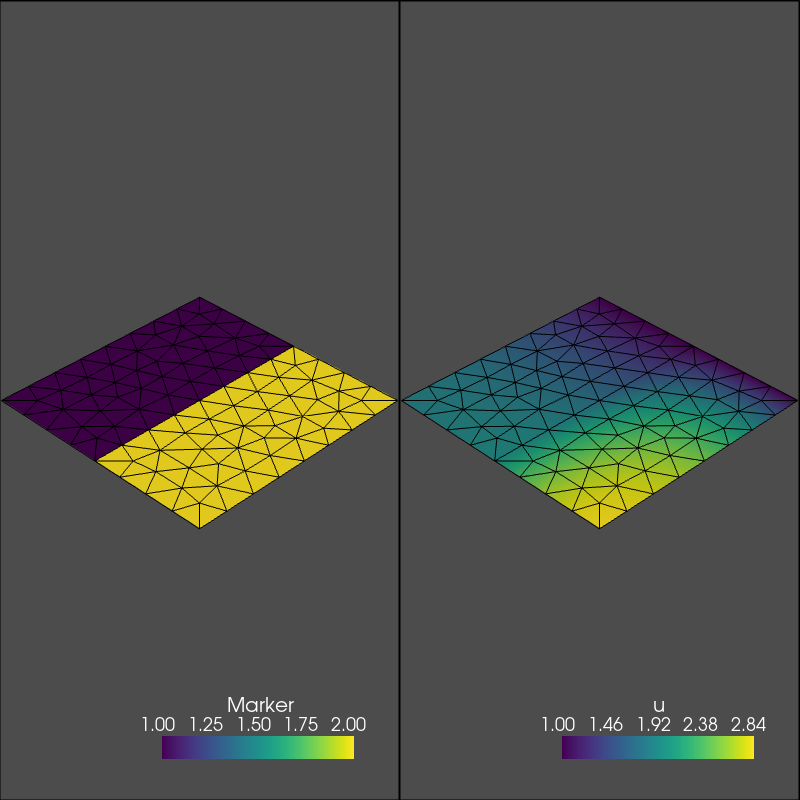

In [15]:
import ufl
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = ufl.inner(kappa*ufl.grad(u), ufl.grad(v))*ufl.dx
x = ufl.SpatialCoordinate(mesh)
L = dolfinx.Constant(mesh, 1) * v * ufl.dx

problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# As the dolfinx.MeshTag contains a value for every cell in the
# geometry, we can attach it directly to the grid

topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_arrays["Marker"] = ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")

p = pyvista.Plotter(window_size=[800, 800], shape=(1,2))
p.subplot(0,0)
p.add_mesh(grid, show_edges=True)
p.subplot(0,1)
point_values = uh.compute_point_values()
if np.iscomplexobj(point_values):
    point_values = point_values.real
grid.point_arrays["u"] = point_values
grid.set_active_scalars("u")
actor1 = p.add_mesh(grid, show_edges=True)
if not pyvista.OFF_SCREEN:
    p.show()
figure = p.screenshot("subdomains_unstructured.png")